In [1]:
import os, csv
import pandas as pd

input_directory = 'data/personal'
input_filename = 'gnss_log_2020_12_03_19_43_12.txt'

with open(os.path.join(input_directory, input_filename)) as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        if row[0][0] == '#':
            if 'Fix' in row[0]:
                android_fixes = [row[1:]]
            elif 'Raw' in row[0]:
                measurements = [row[1:]]
        else:
            if 'Fix' in row[0]:
                android_fixes.append(row[1:])
            elif row[0] == 'Raw':
                measurements.append(row[1:])

android_fixes = pd.DataFrame(android_fixes[1:], columns = android_fixes[0])
measurements = pd.DataFrame(measurements[1:], columns = measurements[0])

We have now imported the raw GNSS measurements and location fixes from the Android log file.

Let's do a couple unit conversions.

First, we'll calculate the GPS time using the equation:

GpsTime = TimeNanos - (FullBiasNanos + BiasNanos)[ns]

In [2]:
measurements['GpsTimeMillis'] = (pd.to_numeric(measurements['TimeNanos']) - pd.to_numeric(measurements['FullBiasNanos'])) * 1e-6
measurements['ElapsedGpsTimeSeconds'] = (measurements['GpsTimeMillis'] - measurements['GpsTimeMillis'].iloc[0]) * 1e-3

Now let's split the data into measurement epochs. We do this by creating a new column and setting it to 1 whenever the difference between a timestamp and the previous timestamp is greater than 100 milliseconds using the DataFrame.shift() command. Then we use the cumsum method to 

In [3]:
measurements['Epoch'] = 0
measurements.loc[measurements['GpsTimeMillis'] - measurements['GpsTimeMillis'].shift() > 100, 'Epoch'] = 1
measurements['Epoch'] = measurements['Epoch'].cumsum()

In [4]:
measurements.loc[measurements['Svid'].str.len() == 1, 'Svid'] = '0' + measurements['Svid']
measurements.loc[measurements['ConstellationType'] == '1', 'SvName'] = 'G' + measurements['Svid']
measurements.loc[measurements['ConstellationType'] == '3', 'SvName'] = 'R' + measurements['Svid']
measurements['Cn0DbHz'] = pd.to_numeric(measurements['Cn0DbHz'])

Text(0, 0.5, 'Cn0DbHz')

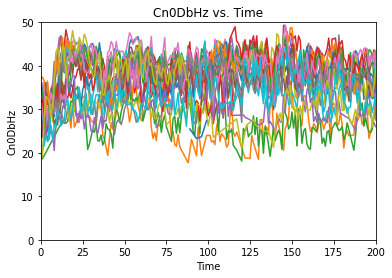

In [5]:
import matplotlib.pyplot as plt

# create a color palette
for satellite in measurements['SvName'].unique():
    one_sat = measurements.loc[measurements['SvName'] == satellite]
    plt.plot(one_sat['ElapsedGpsTimeSeconds'], one_sat['Cn0DbHz'])
    plt.xlim(0, 200)
    plt.ylim(0,50)

# Add titles
plt.title('Cn0DbHz vs. Time')
plt.xlabel("Time")
plt.ylabel('Cn0DbHz')




In [6]:
from src.get_ephemeris import EphemerisManager
import datetime
timestamp = datetime.datetime(2013, 9,1,12,0,1)
manager = EphemerisManager()
ephemeris = manager.get_ephemeris(timestamp, ['G02', 'G05'])
ephemeris.reset_index(inplace=True)


Attempted to retrieve gnss/data/daily/2013/brdc/BRDC00IGS_R_20132440000_01D_MN.rnx.gz from gdc.cddis.eosdis.nasa.gov
550 Failed to open file.
Attempted to retrieve /IGS/BRDC/2013/244/BRDC00WRD_S_20132440000_01D_MN.rnx.gz from igs.bkg.bund.de
550 No such file.


In [7]:
import numpy as np
timestamp = datetime.datetime(2013, 9,1,12,0,0)
def weekseconds(timestamp):
    weekday = timestamp.weekday() + 1
    if weekday == 7:
        weekday = 0
    return 86400 * weekday + 3600 * timestamp.hour + 60 * timestamp.minute + timestamp.second + timestamp.microsecond
    
mu = 3.986005e14
OmegaDot_e = 7.2921151467e-5
sv_position = pd.DataFrame()
ephemeris.rename(columns={'M0':'M_0', 'Eccentricity':'e', 'Toe':'t_oe', 'DeltaN':'deltaN', 'Cuc':'C_uc', 'Cus':'C_us', 'Cic':'C_ic', 'Crc':'C_rc', 'Cis':'C_is', 'Crs':'C_rs', 'Io':'i_0', 'Omega0':'Omega_0'}, inplace=True)
sv_position['sv'] = ephemeris['sv']

sv_position['t'] = weekseconds(timestamp)
sv_position['t_k'] = 17 + weekseconds(timestamp) - ephemeris['t_oe']
A = ephemeris['sqrtA'].pow(2)
n_0 = np.sqrt(mu / A.pow(3))
n = n_0 + ephemeris['deltaN']
M_k = ephemeris['M_0'] + n * sv_position['t_k']
E_k = M_k
err = pd.Series(data=[1]*len(sv_position.index))
i = 0
while err.abs().min() > 1e-8 and i < 10:
    new_vals = M_k + ephemeris['e']*np.sin(E_k)
    err = new_vals - E_k
    E_k = new_vals
    i += 1

cosE_k = np.cos(E_k)
v_k = np.arctan2(np.sqrt(1-ephemeris['e'].pow(2))*np.sin(E_k),(cosE_k - ephemeris['e']))
v_k1 = np.arctan2(np.sqrt(1-ephemeris['e'].pow(2))*np.sin(E_k)/(1-ephemeris['e']*cosE_k),(cosE_k - ephemeris['e'])/(1-ephemeris['e']*cosE_k))
Phi_k = v_k + ephemeris['omega']

sin2Phi_k = np.sin(2*Phi_k)
cos2Phi_k = np.cos(2*Phi_k)

du_k = ephemeris['C_us']*sin2Phi_k + ephemeris['C_uc']*cos2Phi_k
dr_k = ephemeris['C_rs']*sin2Phi_k + ephemeris['C_rc']*cos2Phi_k
di_k = ephemeris['C_is']*sin2Phi_k + ephemeris['C_ic']*cos2Phi_k

u_k = Phi_k + du_k

r_k = A*(1 - ephemeris['e']*np.cos(E_k)) + dr_k
r_k1 = A*((1 - ephemeris['e'].pow(2))/(1 + ephemeris['e']*np.cos(v_k))) + dr_k
i_k = ephemeris['i_0'] + di_k + ephemeris['IDOT']*sv_position['t_k']

x_k_prime = r_k*np.cos(u_k)
y_k_prime = r_k*np.sin(u_k)


Omega_k = ephemeris['Omega_0'] + (ephemeris['OmegaDot'] - OmegaDot_e)*sv_position['t_k'] - OmegaDot_e*ephemeris['t_oe']

sv_position['x_k'] = x_k_prime*np.cos(Omega_k) - y_k_prime*np.cos(i_k)*np.sin(Omega_k)
sv_position['y_k'] = x_k_prime*np.sin(Omega_k) + y_k_prime*np.cos(i_k)*np.cos(Omega_k)
sv_position['z_k'] = y_k_prime*np.sin(i_k)
